In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from data_in import data_in, normali
from modify_model import modify_model
from orignal_model import ori_model
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, y_train = data_in()

In [3]:
#Nomalization
y_train = (y_train-50)/150
X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (3203, 1000, 5)
Shape of y_train is: (3203, 1)


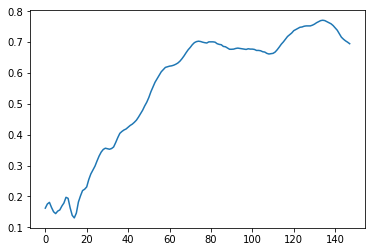

In [6]:
plt.plot(y_train[:148])

In [4]:
X_train_PPG = X_train[:, :, :2]
X_train_acc = X_train[:, :, 2:]

Heart rate is: [79.5990566]


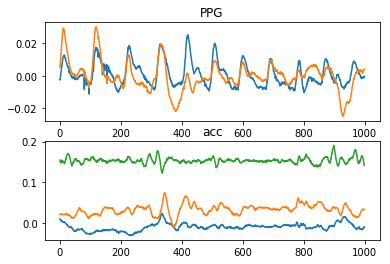

In [5]:
num_in = 10
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [6]:
fir_model = ori_model((1000, 5), 16)

/Users/xufanxiong/Desktop/Troika_1/orignal_model.py:199: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [7]:
optm = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
fir_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [8]:
filepath="weight_troika_ori.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = fir_model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 1414 samples, validate on 354 samples
Epoch 1/200
 256/1414 [====>.........................] - ETA: 1:38 - loss: 0.5330 - mean_squared_error: 0.0253

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
filepath="weight_troika_ori.hdf5"
fir_model.load_weights(filepath)

In [ ]:
#fir_model.summary()

In [ ]:
#Evaluate
#eva = finalmodel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
#print('loss = ' + str(eva[0]))
#print('Test MSE = ' + str(eva[1]))

In [ ]:
pred_label = fir_model.predict(X_train)

In [ ]:
mod_model, y_mod_label = modify_model((1000, 5), y_train, pred_label, 8)

In [ ]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
mod_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [ ]:
filepath="weight_troika_ori_modify.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = mod_model.fit(X_train, y_mod_label, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
mod_model.load_weights('weight_troika_final_modify.hdf5')

In [ ]:
#Import Test
X_test = sio.loadmat('Training_data/DATA_06_TYPE02.mat')
y_test = sio.loadmat('Training_data/DATA_06_TYPE02_BPMtrace.mat')
X_test = X_test['sig'].T
y_test = y_test['BPM0']
print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

In [ ]:
#Split data
tem = X_test[:, 1:]
X_test = np.zeros((y_test.shape[0], 125*8, 5))
k = 0

for i in range(y_test.shape[0]):
    X_test[i, :, :] = tem[k:(k+125*8), :]
    k += 2*125
    
tem = 0

y_test = (y_test-50)/150
X_test = normali(X_test)

print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

In [ ]:
predict = finalmodel.predict(X_test)
predict_mod = mod_model.predict(X_test)

In [ ]:
plt.subplot(211)
plt.plot(y_test)
plt.plot(predict)
plt.title('Before modify')
plt.subplot(212)
plt.plot(y_test)
plt.plot(predict+predict_mod)
plt.title('After modify')
plt.show()